In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import casadi as ca
import pandas as pd

# General Pipline

![](./safety_pipline.png)


# Load track data

In [2]:
# 1. set file path
file_path = "Monza.csv"

# 2. read csv file
df = pd.read_csv(file_path)

# 3. look head
print(df.head())

# 4. rename the first row
##df.rename(columns={'# x_m': 'x_m'}, inplace=True)

# 5. read the columns
x = df['# x_m'].values
y = df['y_m'].values
w_left = df['w_tr_left_m'].values
w_right = df['w_tr_right_m'].values

      # x_m        y_m  w_tr_right_m  w_tr_left_m
0 -0.320123   1.087714         5.739        5.932
1  0.168262   6.062191         5.735        5.929
2  0.656139  11.036647         5.731        5.926
3  1.143549  16.011082         5.727        5.923
4  1.630535  20.985493         5.723        5.920


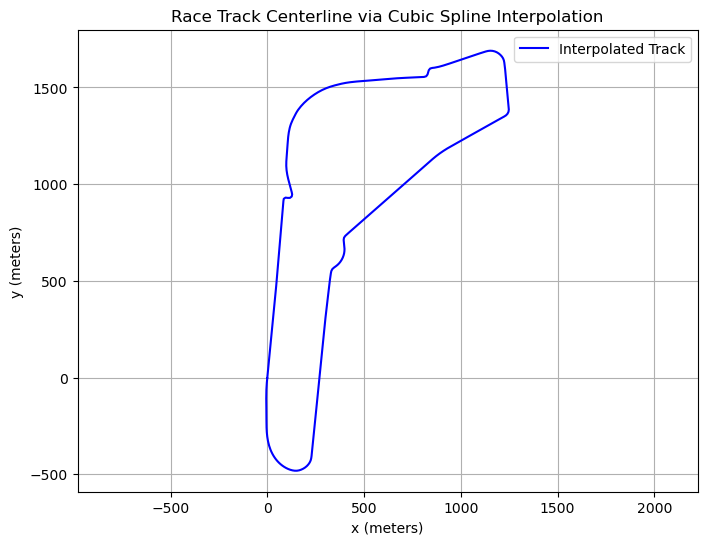

In [3]:
# Step 1: Compute arclengths
s = np.zeros(len(x))
s[1:] = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
s_max=s[-1] #the length of the track

# Step 2: Create cubic spline interpolators
x_spline = CubicSpline(s, x)
y_spline = CubicSpline(s, y)

# Step 3: Get the first and second derivative of the parameteriation
dx_ds = x_spline.derivative(1)
d2x_ds2 = x_spline.derivative(2)
dy_ds = y_spline.derivative(1)
d2y_ds2 = y_spline.derivative(2)

## Generate interpolated values for plotting
s_query = np.linspace(0, s_max, 500)
x_interp = x_spline(s_query)
y_interp = y_spline(s_query)

## Plot the spline
plt.figure(figsize=(8, 6))
plt.plot(x_interp, y_interp, label='Interpolated Track', color='blue')
##plt.plot(x, y, 'ro', label='Original Points')
plt.axis('equal')
plt.title('Race Track Centerline via Cubic Spline Interpolation')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.legend()
plt.grid(True)
plt.show()

# output parameterisation and curvature as a casadi instance
x_ref = ca.interpolant('x_ref', 'linear', [s_query], x_interp)
y_ref = ca.interpolant('y_ref', 'linear', [s_query], y_interp)
kappa_ref_ = dx_ds(s_query)*d2y_ds2(s_query)-dy_ds(s_query)*d2x_ds2(s_query)
kappa_ref = ca.interpolant('kappa', 'linear', [s_query], kappa_ref_)

# Load global trajectory

In [831]:
# file path
file_path = './optimal_trajectory_1.csv'

# read CSV
df = pd.read_csv(file_path)

# look first 5 entry
print(df.head())


      s          v      beta     omega             n        xi     delta  \
0   0.0  10.000000  0.000000  0.000000  0.000000e+00  0.000000  0.019703   
1   3.0  10.060300  0.000042  0.000387  9.326291e-08 -0.000015  0.016407   
2   6.0  10.120099 -0.000037  0.000706  8.033378e-05  0.000070  0.013634   
3   9.0  10.179402 -0.000213  0.000969  1.794186e-04  0.000236 -0.013564   
4  12.0  10.238221 -0.000501  0.000688  2.474330e-04  0.000480 -0.015080   

         F_dr  
0  435.857199  
1  435.508531  
2  435.143993  
3  434.794007  
4  434.417913  


In [832]:
s     = df['s'].to_numpy()
v     = df['v'].to_numpy()
beta  = df['beta'].to_numpy()
omega = df['omega'].to_numpy()
n     = df['n'].to_numpy()
xi    = df['xi'].to_numpy()
delta = df['delta'].to_numpy()
F_dr  = df['F_dr'].to_numpy()

In [909]:
#  Use boolean indexing to filter rows where s is between 3690 and 3972.
mask = (df['s'] >= 4323) & (df['s'] <= 4353)
df_sub = df.loc[mask]

#  Get corresponding values 
s_sub     = df_sub['s'].to_numpy()
v_sub     = df_sub['v'].to_numpy()
beta_sub  = df_sub['beta'].to_numpy()
omega_sub = df_sub['omega'].to_numpy()
n_sub     = df_sub['n'].to_numpy()
xi_sub    = df_sub['xi'].to_numpy()
delta_sub = df_sub['delta'].to_numpy()[:-1]
Fdr_sub   = df_sub['F_dr'].to_numpy()[:-1]

In [910]:
n_sub.shape

(11,)

# Safety check problem formulation (A)

$$
\begin{aligned}
&\min\; v(s_{fov})\\
\text{s.t.}\quad
&\frac{dx}{ds} = f\bigl(x(s),u(s)\bigr) &&(\text{Car Dynamics Constraints})\\
&h\bigl(x(s),u(s)\bigr) \le 0        &&(\text{Environment Constraints})\\
&x(s_0) = x_0                       &&(\text{Initial State Constraints})\\
&v(s)>0,\quad s\in[s_0,s_{fov}]     &&(\text{Feasibility Constraint})
\end{aligned}
$$

If the optimized result $v_(s_{fov})$ is smaller than $v_0$, then safety is assured.

In [930]:
##==car parameter==##
m = 1500
g = 9.81
mu_roll = 0.008
mu = 1
F_MAX = 2000
F_MIN = -13200 ##breaking force
delta_MAX = np.pi / 6
J_zz = 3000
l_f = 1.5
l_r = 1.5
w_f = 1.2
w_r = 1.2
##================##

##==Initialize the independent variable (i.e. s)==#
s0 = 4323 ## position of the car
S_fov = 4353 ## boundary of FOV
ds = 3 ## step size for the arclength
N = int((S_fov-s0)/ds+1) ## number of discretization
s = np.linspace(s0,S_fov,N)
# or can take the s from data

opti = ca.Opti()

# Variables
n = opti.variable(N)
xi = opti.variable(N)
beta = opti.variable(N)
psi_dot = opti.variable(N)
v = opti.variable(N)
delta_f = opti.variable(N-1)
F_dr = opti.variable(N-1)
dtds = opti.variable(N)

##==Get the global solution for states and corresponding control from s0 to S_fov==##
#They are used as initial guess for opti
n_guess = n_sub
xi_guess = xi_sub
beta_guess = beta_sub
psi_dot_guess = omega_sub
v_guess = v_sub
delta_f_guess = delta_sub
F_dr_guess = Fdr_sub

##==Define some constants==##
F_roll = mu_roll * m * g
F_Z = m * g / 4
v0=0.5

for k in range(N-1):
    kappa = kappa_ref(s[k])
    # slip angle for 4 tyres
    alpha_fl = delta_f[k] - ca.atan2(v[k]*ca.sin(beta[k]) + l_f*psi_dot[k], v[k]*ca.cos(beta[k]) - w_f/2*psi_dot[k])
    alpha_fr = delta_f[k] - ca.atan2(v[k]*ca.sin(beta[k]) + l_f*psi_dot[k], v[k]*ca.cos(beta[k]) + w_f/2*psi_dot[k])
    alpha_rl = 0 - ca.atan2(v[k]*ca.sin(beta[k]) - l_r*psi_dot[k], v[k]*ca.cos(beta[k]) - w_r/2*psi_dot[k])
    alpha_rr = 0 - ca.atan2(v[k]*ca.sin(beta[k]) - l_r*psi_dot[k], v[k]*ca.cos(beta[k]) + w_r/2*psi_dot[k])
    # magical formula for tyre lateral force
    F_y = lambda alpha: ca.sin(1.9 * ca.atan(10 * ca.sin(alpha))) + 0.97 * ca.sin(ca.atan(10 * ca.sin(alpha)))
    FYfl = F_y(alpha_fl)
    FYfr = F_y(alpha_fr)
    FYrl = F_y(alpha_rl)
    FYrr = F_y(alpha_rr)
    # system dynamics

    dn = dtds[k] * (v[k]*ca.sin(xi[k] + beta[k]))
    dxi = dtds[k] * psi_dot[k] - kappa
    dbeta = dtds[k] * (-psi_dot[k] + 1/(m*v[k]) * (
        (FYfl + FYfr)*ca.cos(delta_f[k] - beta[k]) +
        (FYrl + FYrr)*ca.cos(- beta[k]) - F_dr[k]*ca.sin(beta[k])
    ))
    dpsi_dot = dtds[k]/J_zz * (
        FYfl*(l_f*ca.cos(delta_f[k]) - w_f/2*ca.sin(delta_f[k])) +
        FYfr*(l_f*ca.cos(delta_f[k]) + w_f/2*ca.sin(delta_f[k])) +
        FYrl*(-l_r) +
        FYrr*(-l_r)
    )
    dv = dtds[k]/m * (
        (FYfl + FYfr)*ca.sin(beta[k] - delta_f[k]) +
        (FYrl + FYrr)*ca.sin(beta[k]) +
        F_dr[k]*ca.cos(beta[k]) - F_roll
    )
    # equality constraint
    opti.subject_to(dtds[k] == (1 - n[k]*kappa) / v[k]*ca.cos(xi[k] + beta[k]))

    # Integrate
    opti.subject_to(n[k+1] == n[k] + ds*dn)
    opti.subject_to(xi[k+1] == xi[k] + ds*dxi)
    opti.subject_to(beta[k+1] == beta[k] + ds*dbeta)
    opti.subject_to(psi_dot[k+1] == psi_dot[k] + ds*dpsi_dot)
    opti.subject_to(v[k+1] == v[k] + ds*dv)

    # Control and friction constraints
    opti.subject_to(F_dr[k] <= F_MAX)
    opti.subject_to(F_dr[k] >= F_MIN)
    opti.subject_to(ca.fabs(delta_f[k]) <= delta_MAX)

    opti.subject_to((FYfl/(mu*F_Z))**2 + (0.25*F_roll/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYfr/(mu*F_Z))**2 + (0.25*F_roll/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYrl/(mu*F_Z))**2 + (0.25*(F_dr[k]+F_roll)/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYrr/(mu*F_Z))**2 + (0.25*(F_dr[k]+F_roll)/(mu*F_Z))**2 <= 1)

# Initial state constraint
opti.subject_to(n[0] == n_guess[0])
opti.subject_to(xi[0] == xi_guess[0])
opti.subject_to(beta[0] == beta_guess[0])
opti.subject_to(psi_dot[0] == psi_dot_guess[0])
opti.subject_to(v[0] == v_guess[0])  ##刹车时的速度

# Final state constraint
# first consider no finial state constraint
#opti.subject_to(n[N-1] == 0)
#opti.subject_to(xi[N-1] == 0)
#opti.subject_to(beta[N-1] == 0)
#opti.subject_to(psi_dot[N-1] == 0)
#opti.subject_to(v[N-1] == 0.02)

# State constraint
for k in range(N):
    opti.subject_to(v[k] >= 0.1)
    nmin, nmax = -10, 10
    opti.subject_to(n[k] >= nmin)
    opti.subject_to(n[k] <= nmax)
# Avoid accelerating when braking
for k in range(N-1):
    opti.subject_to(F_dr[k] <= 1) # less than 1 rather than 0 to avoid 0 speed 

# Objective
opti.minimize(v[N-1]**2)

opti.set_initial(n, n_guess)
opti.set_initial(xi, xi_guess)
opti.set_initial(beta, beta_guess)
opti.set_initial(psi_dot, psi_dot_guess)
opti.set_initial(v, v_guess)
opti.set_initial(delta_f, delta_f_guess)
opti.set_initial(F_dr, -np.abs(F_dr_guess)) # Set the initial guess for the braking force to the negative of the absolute value of the global solution



In [938]:
opti.solver('ipopt', {"expand": True}, {
        "print_level": 0, "tol": 1e-4,
        "acceptable_tol": 1e-2, "acceptable_iter": 10,
        "max_iter": 5000,
        "constr_viol_tol": 1e-3,
        "compl_inf_tol": 1e-3,
        "acceptable_constr_viol_tol": 1e-3,
    })

In [939]:
print(F_dr_guess)

[405.23906165 405.02832792 405.02551046 405.14300727 405.39496047
 405.9966523  406.6430238  407.35515165 408.1250082  408.94505246]


In [940]:
sol = opti.solve()

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  46.00us (  1.00us)  40.66us (884.02ns)        46
       nlp_g  | 536.00us ( 11.65us) 503.45us ( 10.94us)        46
  nlp_grad_f  |  59.00us (  1.31us)  52.75us (  1.17us)        45
  nlp_hess_l  |   2.79ms ( 64.95us)   2.79ms ( 64.99us)        43
   nlp_jac_g  |   1.25ms ( 27.87us)   1.26ms ( 28.03us)        45
       total  |  41.58ms ( 41.58ms)  41.57ms ( 41.57ms)         1


In [941]:
opti.debug.value(F_dr)

array([ 9.20701029e-01, -5.05280754e+03, -1.31999418e+04, -1.31999583e+04,
       -1.31999692e+04, -1.31999768e+04, -1.31999822e+04, -1.31999860e+04,
       -1.31999883e+04, -1.31999893e+04])

In [942]:
opti.debug.value(v)

array([18.40606103, 18.39290254, 17.93055687, 16.71977765, 15.45888876,
       14.15226044, 12.81396263, 11.47770438, 10.21459239,  9.15524874,
        8.47922499])

In [936]:
opti.debug.value(n)

array([-4.34094584, -4.30531008, -4.27075024, -4.28914683, -4.45233863,
       -4.78820821, -5.33038325, -6.11602546, -7.17591219, -8.50486436,
       -9.99999632])

In [937]:
opti.debug.value(delta_f)

array([0.52326338, 0.52317638, 0.52306092, 0.52287462, 0.5225028 ,
       0.5214908 , 0.51385174, 0.22951615, 0.20588427, 0.30497645])

In [879]:
opti.debug.value(s)

array([4323., 4326., 4329., 4332., 4335., 4338., 4341., 4344., 4347.,
       4350., 4353., 4356., 4359., 4362., 4365., 4368., 4371., 4374.,
       4377., 4380., 4383.])

In [880]:
opti.debug.value(xi)

array([0.63629104, 0.62621612, 0.61617633, 0.60617116, 0.59619978,
       0.58626129, 0.57636923, 0.56652988, 0.55674213, 0.54700485,
       0.53734505, 0.52766518, 0.51739925, 0.50643784, 0.49463941,
       0.48182221, 0.46775576, 0.45217258, 0.4348721 , 0.41620327,
       0.39855566])

In [881]:
opti.debug.value(psi_dot)

array([-0.05943849, -0.05948329, -0.05952848, -0.05957408, -0.05962009,
       -0.05966654, -0.05971343, -0.05976078, -0.0598086 , -0.05985692,
       -0.05990574, -0.05995523, -0.06000642, -0.06005944, -0.06011445,
       -0.06017158, -0.06023085, -0.06029163, -0.06030546, -0.06031447,
       -0.06033202])

In [882]:
opti.debug.value(beta)

array([-0.62441791, -0.60779987, -0.59153857, -0.57562378, -0.56004531,
       -0.5447931 , -0.52985746, -0.51522875, -0.50089733, -0.4868538 ,
       -0.47899151, -0.50082178, -0.52763986, -0.56126153, -0.60447046,
       -0.66171079, -0.74038122, -0.85321119, -1.0217947 , -1.27536056,
       -1.60461821])

# Decelerate for safety (C)

$$
\begin{aligned}
&\min\; v(s_{fov})\\
\text{s.t.}\quad
&\frac{dx}{ds} = f\bigl(x(s),u(s)\bigr) &&(\text{Car Dynamics Constraints})\\
&h\bigl(x(s),u(s)\bigr) \le 0        &&(\text{Environment Constraints})\\
&\bar{x}(s) = \bar{x}_{global}(s) \text{ for all }s \in (s_0,s_{fov}]                      &&(\text{Following the geometric path from global solution})\\
&x(s_0) = x_0                       &&(\text{Initial state constraint})\\
&v(s)>0,\quad s\in[s_0,s_{fov}]     &&(\text{Feasibility Constraint})
\end{aligned}
$$

$\bar{x}$ is the car's state excluding speed. Then take the first control step

# Maximize speed when safety assured (B)

$$
\begin{aligned}
&\max\; \int_{s_0}^{s_0+H} v(s)^2 \, ds\\
\text{s.t.}\quad
&\frac{dx}{ds} = f\bigl(x(s),u(s)\bigr) &&(\text{Car Dynamics Constraints})\\
&h\bigl(x(s),u(s)\bigr) \le 0        &&(\text{Environment Constraints})\\
&\bar{x}(s) = \bar{x}_{global}(s) \text{ for all }s \in (s_0,s_{fov}]                      &&(\text{Following the geometric path from global solution})\\
&x(s_0) = x_0                       &&(\text{Initial state constraint})\\
&v(s)>0,\quad s\in[s_0,s_{fov}]     &&(\text{Feasibility Constraint})
\end{aligned}
$$

$\bar{x}$ is the car's state excluding speed, H is the predictive horizon which could be farther than fov. Then take the first control step